## Word Embeddings

- [Word Embeddings](https://towardsdatascience.com/a-guide-to-word-embeddings-8a23817ab60f)

Word Embeddings are dense representations of the individual words in a text, taking into account the context and other surrounding words that that individual word occurs with.
The dimensions of this real-valued vector can be chosen and the semantic relationships between words are captured more effectively than a simple Bag-of-Words Model.
Simply put, words possessing similar meanings or often occuring together in similar contexts, will have a similar vector representation, based on how “close” or “far apart” those words are in their meanings.

![representation](https://miro.medium.com/v2/resize:fit:2000/format:webp/1*SYiW1MUZul1NvL1kc1RxwQ.png)


### 1) Data Preprocessing —

In the first model, we will be training a neural network to learn an embedding from our corpus of text. Specifically, we will supply word tokens and their indexes to an Embedding Layer in our neural network using the Keras library.

There are some key parameters that have to be decided upon before training our network. These include the size of the vocabulary or the number of unique words in our corpus and the dimension of our embedded vectors.

There are 2 datasets provided. We’ll now import them and only retain the questions and the quality columns for analysis.

I’ve also changed the column names and defined a function text_clean to clean up the questions.

In [6]:
# data manipulation and handling
import pandas as pd
import numpy as np
# data visualization
import matplotlib.pyplot as plt
import seaborn as sb
# NLP
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess

stop_words = set(stopwords.words('english'))

# importing the dataset
dataset = pd.read_csv('data/train.csv')[['Body', 'Y']].rename(columns = {'Body': 'question', 'Y': 'category'})
ds = pd.read_csv('data/valid.csv')[['Body', 'Y']].rename(columns = {'Body': 'question', 'Y': 'category'})

# Cleaning up symbols & HTML tags
symbols = re.compile(pattern = '[/<>(){}\[\]\|@,;]')
tags = ['href', 'http', 'https', 'www']

def text_clean(s: str) -> str:
    s = symbols.sub(' ', s)
    for i in tags:
        s = s.replace(i, ' ')

    return ' '.join(word for word in simple_preprocess(s) if not word in stop_words)

dataset.iloc[:, 0] = dataset.iloc[:, 0].apply(text_clean)
ds.iloc[:, 0] = ds.iloc[:, 0].apply(text_clean)

# Train & Test subsets
X_train, y_train = dataset.iloc[:, 0].values, dataset.iloc[:, 1].values.reshape(-1, 1)
X_test, y_test = ds.iloc[:, 0].values, ds.iloc[:, 1].values.reshape(-1, 1)

# OHE the Categorical column
from sklearn.preprocessing import OneHotEncoder as ohe
from sklearn.compose import ColumnTransformer

ct = ColumnTransformer(transformers = [('one_hot_encoder', ohe(categories = 'auto'), [0])],
                       remainder = 'passthrough')

y_train = ct.fit_transform(y_train)
y_test = ct.transform(y_test)

# Setting some paramters
vocab_size = 2000
sequence_length = 100


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alphaprime/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 2) Tokenization —

Next, we’ll be using the Keras Tokenizer class to convert our questions which are still composed of words into an array representing the words with their indices.

So we’ll first have to build an indexed vocabulary out of the words appearing in our dataset, with the **fit_on_texts** method.

After the vocabulary has been built, we use the **text_to_sequences** method to convert sentences into a list of numbers representing words.

The **pad_sequences** function ensures that all observations are of the same length, set to either an arbitrary number or to the length of the longest question in the dataset.

The **vocab_size** parameter we initialized previously is simply the size of our vocabulary of unique words (to learn and index).



When preparing sequences of textual data for machine learning, especially in Natural Language Processing (NLP) tasks such as sentiment analysis, machine translation, or question answering systems, the sequences often need to be the same length because most machine learning models require input data of consistent dimensions.

However, natural language sentences don't all have the same length. One sentence might have five words, while another might have fifteen. To address this, one common approach is to use padding.

Padding is the process of adding filler values (usually zeros) to your sequences to make them all the same length. This process is typically done after tokenization - where sentences are split into individual words (or "tokens"), and each word is then represented by a numerical value (its "token").

For example, if you decide to pad your sequences to a length of ten tokens and you have a sentence that is five tokens long, you would add five zeros to that sentence - either at the beginning (pre-padding), the end (post-padding), or both.

By using the pad_sequences function from Keras, you can easily pad your tokenized sequences to the length you specify.

In summary, padding is used to ensure that all sequences are the same length so they can be fed into machine learning models. Zeros are typically used for padding because they don't carry any meaningful information, so the model can learn to ignore them.

In [8]:
# Tokenization with Keras
from keras.preprocessing.text import Tokenizer

tk = Tokenizer(num_words = vocab_size)
tk.fit_on_texts(X_train)

X_train = tk.texts_to_sequences(X_train)
X_test = tk.texts_to_sequences(X_test)

# Padding all questions with zeros
from keras.preprocessing.sequence import pad_sequences

X_train_seq = pad_sequences(X_train, maxlen = sequence_length, padding = 'post')
X_test_seq = pad_sequences(X_test, maxlen = sequence_length, padding = 'post')

### 3) Training the Embedding Layer —

Finally, in this part, we’ll build and train our model which consists of 2 main layers, an Embedding layer that will learn from our training documents prepared above and a Dense output layer to implement the classification task.

The embedding layer will learn the word representations, along with the neural network while training and requires a lot of text data to provide accurate predictions. In our case, the 45,000 training observations are sufficient to effectively learn the corpus and classify the quality of questions asked. As we will see from the metrics.

In [ ]:
# Training the Embedding Layer & the Neural Network
from keras.models import Sequential
from keras.layers import Embedding, Dense, Flatten

model = Sequential()
model.add(Embedding(input_dim = vocab_size, output_dim = 5, input_length = sequence_length))
model.add(Flatten())

model.add(Dense(units = 3, activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy',
              optimizer = 'rmsprop',
              metrics = ['accuracy'])

model.summary()

history = model.fit(X_train_seq, y_train, epochs = 20, batch_size = 512, verbose = 1)

# Save model once done training
#model.save("model.h5")

### 4) Evaluation & Metric Plots —

All that’s left is to evaluate our model’s performance and also draw plots to view how the accuracy & the loss metrics of the model change with epochs.

Our model’s performance metrics are displayed in the screenshot below.

469/469 [==============================] - 0s 281us/step - loss: 0.4653 - accuracy: 0.8049

Accuracy: 0.8048666715621948
Loss: 0.4652538597583771


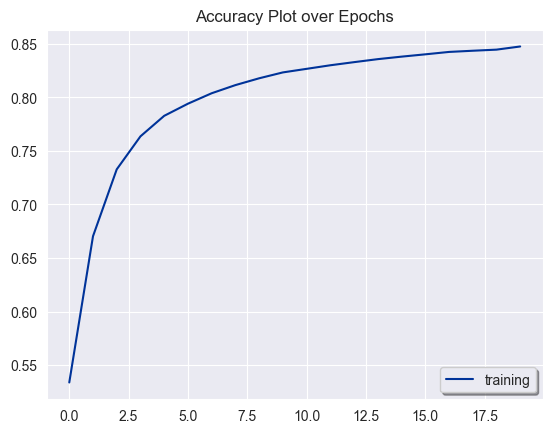

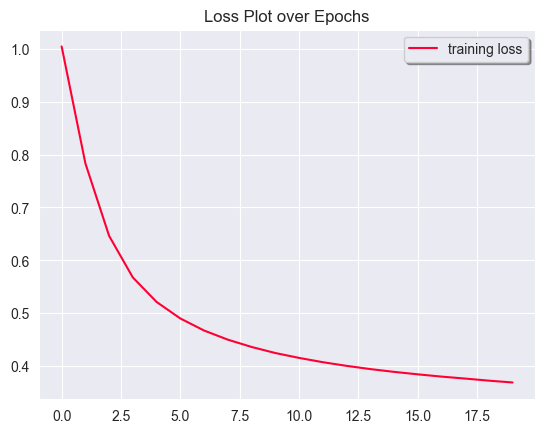

In [13]:
# Evaluating model performance on test set
loss, accuracy = model.evaluate(X_test_seq, y_test, verbose = 1)
print("\nAccuracy: {}\nLoss: {}".format(accuracy, loss))

# Plotting Accuracy & Loss over epochs
sb.set_style('darkgrid')

# 1) Accuracy
plt.plot(history.history['accuracy'], label = 'training', color = '#003399')
plt.legend(shadow = True, loc = 'lower right')
plt.title('Accuracy Plot over Epochs')
plt.show()

# 2) Loss
plt.plot(history.history['loss'], label = 'training loss', color = '#FF0033')
plt.legend(shadow = True, loc = 'upper right')
plt.title('Loss Plot over Epochs')
plt.show()